This is a Julian fork of the 12 steps to Navier-Stokes (Python) [https://github.com/barbagroup/CFDPython] by Lorena A. Barba, Gilbert F. Forsyth . All content of that work is under Creative Commons Attribution CC-BY 4.0, and all python code is under BSD-3 clause. This work also derives from similar forks by Cysor [https://github.com/Cysor/CFDJulia] and by Wallace-dyfq [https://github.com/Wallace-dyfq/CFD-Julia-12-steps--o-Navier-Stokes-Equations]

Did you make it this far? This is the last step! How long did it take you to write your own Navier-Stokes solver in Julia following this interactive module? Let us know!

Step 12: Channel Flow with Navier-Stokes
----
***

The only difference between this final step and Step 11 is that we are going to add a source term to the $u$-momentum equation, to mimic the effect of a pressure-driven channel flow. Here are our modified Navier-Stokes equations:

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)+F$$

$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)$$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = \rho\left(\frac{\partial }{\partial t}\left(\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}\right) - \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} - 2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x} - \frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$

### Discretized equations

With patience and care, we write the discretized form of the equations. It is highly recommended that you write these in your own hand, mentally following each term as you write it.

The $u$-momentum equation:

\begin{eqnarray}
&&\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y}\\\
&&=-\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}\\\
&&+\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)+F_{i,j}
\end{eqnarray}

The $v$-momentum equation:

\begin{eqnarray}
&&\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y}\\\
&&=-\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}\\\
&&+\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
\end{eqnarray}

And the pressure equation:

\begin{eqnarray}
&&\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2*p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}\\\
&&=\rho\left(\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)\right.\\\
&&-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\\\
&&-2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}\\\
&&-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)
\end{eqnarray}

As always, we need to re-arrange these equations to the form we need in the code to make the iterations proceed. 

For the $u$- and $v$ momentum equations, we isolate the velocity at time step `n+1`:

$$u_{i,j}^{n+1} = u_{i,j}^{n} - u_{i,j}^{n}\frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n})-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})$$
$$-\frac{\Delta t}{\rho 2\Delta x}(p_{i+1,j}^{n}-p_{i-1,j}^{n})+\nu\left[\frac{\Delta t}{\Delta x^2}(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n})\right.$$
$$+\left.\frac{\Delta t}{\Delta y^2}(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n})\right] + F\Delta t$$

$$v_{i,j}^{n+1}=v_{i,j}^{n} - u_{i,j}^{n}\frac{\Delta t}{\Delta x}(v_{i,j}^{n}-v_{i-1,j}^{n})-v_{i,j}^{n}\frac{\Delta t}{\Delta y}(v_{i,j}^{n}-v_{i,j-1}^{n})$$
$$-\frac{\Delta t}{\rho 2\Delta y}(p_{i,j+1}^{n}-p_{i,j-1}^{n})+\nu\left[\frac{\Delta t}{\Delta x^2}(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n})\right.$$
$$+\left.\frac{\Delta t}{\Delta y^2}(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n})\right]$$

And for the pressure equation, we isolate the term $p_{i,j}^n$ to iterate in pseudo-time:

$$p_{i,j}^{n} = \frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}-\frac{\rho\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}\times$$
$$\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)- \frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} \right.$$
$$- 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]$$

The initial condition is $u, v, p=0$ everywhere, and at the boundary conditions are:

$u, v, p$ are periodic on $x=0,2$

$u, v =0$ at $y =0,2$

$\frac{\partial p}{\partial y}=0$ at $y =0,2$

$F=1$ everywhere.

Let's begin by importing our usual run of libraries:


In [1]:
using PyPlot
using LinearAlgebra

In [26]:
function pressurePoissonPeriodic!(p, x, y, Δx, Δy, u, v; nt_p = 5000, pl1norm_target = 0.001)

    pn = similar(p)
    
    row = size(y,1);    
    col = size(x,1);
    
    pl1norm = 1;    
    it = 1;
    
    while (pl1norm > pl1norm_target && it < nt)
        
        pn .= p;
                
        for j in 1:row
            for i in 1:col
                
                if j == 1
                    p[j,i] = pn[2,i]    #dp/dy = 0 at y = 0
                    
                elseif j == row
                    p[j,i] = pn[row-1,j]    #dp/dy = 0 at y = 2
                
                elseif i == col    #periodic BC at x = 2
                    p[j, i] = ((p[j,1]+p[j,col-1])*Δy^2+(p[j+1,i]+p[j-1,i])*Δx^2)/2.0/(Δx^2+Δy^2) -
                            ρ*Δx^2*Δy^2/2.0/(Δx^2+Δy^2)*( 1.0/Δt*( (u[j,1]-u[j,i-1])/2.0/Δx + (v[j+1,i]-v[j-1,i])/2.0/Δy )
                                -( (u[j,1]-u[j,i-1])/2.0/Δx )^2 - 
                                2.0*( (u[j+1,i]-u[j-1,i])/2.0/Δy*(v[j,1]-v[j,i-1])/2.0/Δx ) -
                                ( (v[j+1,i]-v[j-1,i])/2.0/Δy )^2 )             
                
                elseif i == 1    #periodic BC at x = 0
                    p[j, i] = ((p[j,2]+p[j,col])*Δy^2+(p[j+1,i]+p[j-1,i])*Δx^2)/2.0/(Δx^2+Δy^2) -
                            ρ*Δx^2*Δy^2/2.0/(Δx^2+Δy^2)*( 1.0/Δt*( (u[j,2]-u[j,col])/2.0/Δx + (v[j+1,i]-v[j-1,i])/2.0/Δy )
                                -( (u[j,2]-u[j,col])/2.0/Δx )^2 - 
                                2.0*( (u[j+1,i]-u[j-1,i])/2.0/Δy*(v[j,2]-v[j,col])/2.0/Δx ) -
                                ( (v[j+1,i]-v[j-1,i])/2.0/Δy )^2 )  

                else
                    p[j,i] = ( Δy^2*(pn[j, i+1]+pn[j, i-1]) + Δx^2*(pn[j+1, i]+pn[j-1, i]) )/2.0/(Δx^2 + Δy^2) -   
                        ρ*Δx^2*Δy^2/2.0/(Δx^2+Δy^2)*( 1.0/Δt*( (u[j,i+1]-u[j,i-1])/2.0/Δx + (v[j+1,i]-v[j-1,i])/2.0/Δy )
                                -( (u[j,i+1]-u[j,i-1])/2.0/Δx )^2 - 
                                2.0*( (u[j+1,i]-u[j-1,i])/2.0/Δy*(v[j,i+1]-v[j,i-1])/2.0/Δx ) -
                                ( (v[j+1,i]-v[j-1,i])/2.0/Δy )^2 )
                end
            end
        end
       
            
        pl1norm = norm((p-pn)./(pn.+1.0e-30),1)
        
        it +=1;
        
    end
    
    #@show it, l1norm
    
    return p

end

pressurePoissonPeriodic! (generic function with 1 method)

Now we have our familiar list of variables and initial conditions to declare before we start.

In [27]:
nx = 41
ny = 41

xmin = 0.0
xmax = 2.0

ymin = 0.0
ymax = 2.0

    
Δx = (xmax - xmin) / (nx - 1)
Δy = (ymax - ymin) / (ny - 1)

ρ = 1.0;
ν = 0.1;

F = 1.0

Δt = .01;


x = range(xmin, stop=xmax, length=nx)
y = range(ymin, stop=ymax, length=ny)

p₀ = zeros(ny, nx)
u₀ = zeros(ny, nx)
v₀ = zeros(ny, nx)

        
u₀[end, :] .= 0.0;    #set velocity on cavity lid equal to 1

For the meat of our computation, we're going to reach back to a trick we used in Step 9 for Laplace's Equation.  We're interested in what our grid will look like once we've reached a near-steady state.  We can either specify a number of timesteps `nt` and increment it until we're satisfied with the results, or we can tell our code to run until the difference between two consecutive iterations is very small.  

In [35]:
function channelFlow(u₀, v₀, p₀, Δt, Δx, Δy, ρ, ν; nt = 2000, ul1norm_target = 0.001)
    
    uⁿ⁺¹ = zeros(size(u₀));
    uⁿ = similar(uⁿ⁺¹);
    uⁿ⁺¹ .= u₀;
    
    vⁿ⁺¹ = zeros(size(v₀));
    vⁿ = similar(vⁿ⁺¹);
    vⁿ⁺¹ .= v₀;
    
    p = zeros(size(p₀));
    p .= p₀;
    
    row = size(y,1);    
    col = size(x,1);    

    ul1norm = 1.0;
    it = 1;
    
    while (ul1norm > ul1norm_target && it < nt)  # repeat until the L1 norm of differences in u between iterations is smaller than the target
    
        uⁿ .= uⁿ⁺¹
        vⁿ .= vⁿ⁺¹
    
        pressurePoissonPeriodic!(p, x, y, Δx, Δy, uⁿ, vⁿ; nt_p = 5000, pl1norm_target = 0.001)  # this function directly updates p
        
        for j in 1:row
            for i in 1:col
                
                if j == 1    # wall
                    
                    uⁿ⁺¹[j, i] = 0.0
                    vⁿ⁺¹[j, i] = 0.0
                    
                elseif j == row    # wall
                    
                    uⁿ⁺¹[j, i] = 0.0
                    vⁿ⁺¹[j, i] = 0.0
                    
                elseif i == col  # Periodic BC at x = 2  
                    
                    uⁿ⁺¹[j, i] = ( uⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (uⁿ[j, i] - uⁿ[j, i-1])) - 
                            (vⁿ[j, i]*Δt/Δy * (uⁿ[j, i] - uⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δx*(p[j, 1]-p[j, i-1]) +
                            (ν*Δt/Δx^2*(uⁿ[j, 1] - 2.0*uⁿ[j, i] + uⁿ[j, i-1])) + 
                            (ν*Δt/Δy^2*(uⁿ[j+1, i] - 2.0*uⁿ[j, i] + uⁿ[j-1, i])) ) + F*Δt
                    
                    vⁿ⁺¹[j, i] =  ( vⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (vⁿ[j, i] - vⁿ[j, i-1])) - 
                            (vⁿ[j, i]*Δt/Δy * (vⁿ[j, i] - vⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δy*(p[j+1,i]-p[j-1,i]) +
                            (ν*Δt/Δx^2*(vⁿ[j, 1] - 2.0*vⁿ[j, i] + vⁿ[j, i-1])) + 
                            (ν*Δt/Δy^2*(vⁿ[j+1, i] - 2.0*vⁿ[j, i] + vⁿ[j-1, i])) )                     
                    
                elseif i == 1    #Periodic BC @ x = 0
                    
                    uⁿ⁺¹[j, i] = ( uⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (uⁿ[j, i] - uⁿ[j, col])) - 
                            (vⁿ[j, i]*Δt/Δy * (uⁿ[j, i] - uⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δx*(p[j,i+1]-p[j,col]) +
                            (ν*Δt/Δx^2*(uⁿ[j, i+1] - 2.0*uⁿ[j, i] + uⁿ[j, col])) + 
                            (ν*Δt/Δy^2*(uⁿ[j+1, i] - 2.0*uⁿ[j, i] + uⁿ[j-1, i])) ) + F*Δt
                    
                    vⁿ⁺¹[j, i] = ( vⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (vⁿ[j, i] - vⁿ[j, col])) - 
                            (vⁿ[j, i]*Δt/Δy * (vⁿ[j, i] - vⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δy*(p[j+1,i]-p[j-1,i]) +
                            (ν*Δt/Δx^2*(vⁿ[j, i+1] - 2.0*vⁿ[j, i] + vⁿ[j, col])) + 
                            (ν*Δt/Δy^2*(vⁿ[j+1, i] - 2.0*vⁿ[j, i] + vⁿ[j-1, i])) ) 
               
                else
                    
                    uⁿ⁺¹[j, i] = ( uⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (uⁿ[j, i] - uⁿ[j, i-1])) - 
                            (vⁿ[j, i]*Δt/Δy * (uⁿ[j, i] - uⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δx*(p[j,i+1]-p[j,i-1]) +
                            (ν*Δt/Δx^2*(uⁿ[j, i+1] - 2.0*uⁿ[j, i] + uⁿ[j, i-1])) + 
                            (ν*Δt/Δy^2*(uⁿ[j+1, i] - 2.0*uⁿ[j, i] + uⁿ[j-1, i])) ) + F*Δt
                
                    vⁿ⁺¹[j, i] = ( vⁿ[j, i] - 
                            (uⁿ[j, i]*Δt/Δx * (vⁿ[j, i] - vⁿ[j, i-1])) - 
                            (vⁿ[j, i]*Δt/Δy * (vⁿ[j, i] - vⁿ[j-1, i])) -
                            Δt/ρ/2.0/Δy*(p[j+1,i]-p[j-1,i]) +
                            (ν*Δt/Δx^2*(vⁿ[j, i+1] - 2.0*vⁿ[j, i] + vⁿ[j, i-1])) + 
                            (ν*Δt/Δy^2*(vⁿ[j+1, i] - 2.0*vⁿ[j, i] + vⁿ[j-1, i])) )
                    
                end
            end
        end

        if it%100 == 0
            @show it, ul1norm
        end
        
        ul1norm = norm((uⁿ⁺¹.-uⁿ)./(uⁿ.+1.0e-30),1)
        it += 1;
        
    end

    return uⁿ⁺¹, vⁿ⁺¹, p
    
end

channelFlow (generic function with 2 methods)

In [36]:
u = zeros((ny, nx));
v = zeros((ny, nx));
p = zeros((ny, nx));


tol = 0.001;
u, v, p = channelFlow(u₀, v₀, p₀, Δt, Δx, Δy, ρ, ν);


(it, ul1norm) = (100, 13.11347533058153)
(it, ul1norm) = (200, 5.749169187763498)
(it, ul1norm) = (300, 3.378981051245299)
(it, ul1norm) = (400, 2.2175306582839616)
(it, ul1norm) = (500, 1.5408787635465573)
(it, ul1norm) = (600, 1.108255041153225)
(it, ul1norm) = (700, 0.8153042842540387)
(it, ul1norm) = (800, 0.6091948144081605)
(it, ul1norm) = (900, 0.46026126604376116)
(it, ul1norm) = (1000, 0.35055840325535315)
(it, ul1norm) = (1100, 0.26860675157753994)
(it, ul1norm) = (1200, 0.2067405377053994)
(it, ul1norm) = (1300, 0.15966638180095655)
(it, ul1norm) = (1400, 0.12363172743297653)
(it, ul1norm) = (1500, 0.0959206632716641)
(it, ul1norm) = (1600, 0.07453517894882071)
(it, ul1norm) = (1700, 0.05798634499792676)
(it, ul1norm) = (1800, 0.04515328258840516)
(it, ul1norm) = (1900, 0.03518541596679886)


If you want to see how the number of iterations increases as our `udiff` condition gets smaller and smaller, try defining a function to perform the `while` loop written above that takes an input `udiff` and outputs the number of iterations that the function runs.  

For now, let's look at our results.  We've used the quiver function to look at the cavity flow results and it works well for channel flow, too.  

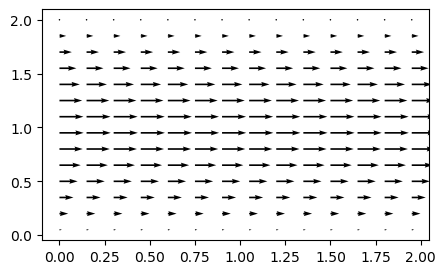

In [37]:
xgrid = repeat(x', nx, 1);
ygrid = repeat(y, 1, ny);

fig = figure(figsize = (5,3), dpi=100)
quiver(xgrid[1:3:end, 1:3:end], ygrid[2:3:end, 2:3:end], u[2:3:end, 2:3:end], v[2:3:end, 2:3:end]);

The structures in the `quiver` command that look like `[1:3:end]` are useful when dealing with large amounts of data that you want to visualize.  The one used above tells `matplotlib` to only plot every 3rd data point.  If we leave it out, you can see that the results can appear a little crowded.  

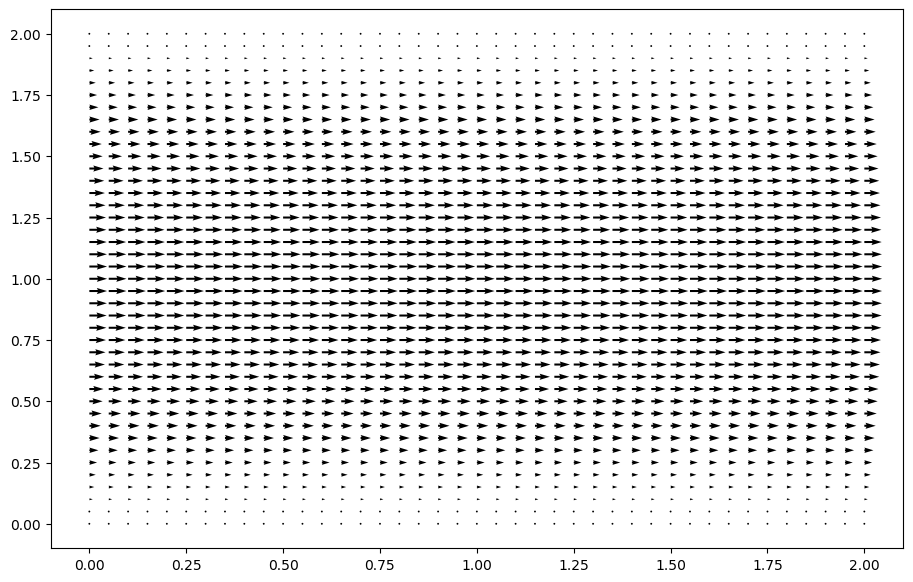

In [38]:
fig = figure(figsize = (11,7), dpi=100)
quiver(x, y, u, v);

## Learn more
***

##### What is the meaning of the $F$ term?

Step 12 is an exercise demonstrating the problem of flow in a channel or pipe. If you recall from your fluid mechanics class, a specified pressure gradient is what drives Poisseulle flow. 

Recall the $x$-momentum equation:

$$\frac{\partial u}{\partial t}+u \cdot \nabla u = -\frac{\partial p}{\partial x}+\nu \nabla^2 u$$

What we actually do in Step 12 is split the pressure into steady and unsteady components $p=P+p'$. The applied steady pressure gradient is the constant $-\frac{\partial P}{\partial x}=F$ (interpreted as a source term), and the unsteady component is $\frac{\partial p'}{\partial x}$. So the pressure that we solve for in Step 12 is actually $p'$, which for a steady flow is in fact equal to zero everywhere.

<b>Why did we do this?</b>

Note that we use periodic boundary conditions for this flow. For a flow with a constant pressure gradient, the value of pressure on the left edge of the domain must be different from the pressure at the right edge. So we cannot apply periodic boundary conditions on the pressure directly. It is easier to fix the gradient and then solve for the perturbations in pressure.

<b>Shouldn't we always expect a uniform/constant $p'$ then?</b>

That's true only in the case of steady laminar flows. At high Reynolds numbers, flows in channels can become turbulent, and we will see unsteady fluctuations in the pressure, which will result in non-zero values for $p'$. 

In step 12, note that the pressure field itself is not constant, but it's the pressure perturbation field that is. The pressure field varies linearly along the channel with slope equal to the pressure gradient. Also, for incompressible flows, the absolute value of the pressure is inconsequential.
